In [3]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [4]:
IMAGE_SIZE_WIDTH = 96
IMAGE_SIZE_HEIGHT = 96

## Load tables

In [5]:
df_dample_submissions = pd.read_csv("data/SampleSubmission.csv")
df_id_lookup_table = pd.read_csv("data/IdLookupTable.csv")
df_train = pd.read_csv("data/training.csv")
df_test = pd.read_csv("data/test.csv")

explore tables

In [6]:
df_dample_submissions

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [7]:
df_id_lookup_table

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [8]:
df_train

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [9]:
df_test

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...,...
1778,1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1779,1780,201 191 171 158 145 140 136 130 123 115 108 10...
1780,1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781,1782,104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...


Show some image and prepare functions for visualizing 

In [14]:
def split(a, n):
    """Split a into n evenly sized chunks"""
    k, m = len(a) // n, len(a) % n
    return [a[i * k:(i + 1) * k] for i in range(n)]


def get_image(encoded_image: str):
    """get image from encoded string"""
    img_arr = list(map(lambda x: int(x), encoded_image.split(' ')))
    img_arr = np.array(split(img_arr, IMAGE_SIZE_WIDTH))

    img = Image.new("L", (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    pixels = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[j, i] = int(img_arr[i][j])
    return img


def check_length(encoded_image: str):
    """checks if encoded image has valid dimensions"""
    assert encoded_image.count(' ') == IMAGE_SIZE_HEIGHT * \
        IMAGE_SIZE_WIDTH - 1, "image size don't equal expected size"


def draw_points(img, points: [], color=(255, 0, 0)):
    """returns image with added points"""
    rgb_img = img.convert('RGB')

    d = ImageDraw.Draw(rgb_img)
    for point in points:
        if np.isnan(point[0]):
            continue

        horizontal_line = [(int(point[0]) - 2, int(point[1])),
                           (int(point[0]) + 2, int(point[1]))]
        vertical_line = [(int(point[0]), int(point[1]) - 2),
                         (int(point[0]), int(point[1]) + 2)]
        d.line(horizontal_line, color)
        d.line(vertical_line, color)

    return rgb_img


def draw_training_record(record):
    """draws facial keypoints to image from dataset record and shows it. parametr record is row from pandas table"""
    points = []
    b = None
    for r in record.to_list()[:-1]:
        if b:
            points.append((b, r))
            b = None
        else:
            b = r

    img = get_image(record.to_list()[-1])
    img_points = draw_points(img, points)

    img_points.show()


def draw_predicted_target(img_arr, prediction, target):
    """Returns image and facial keypoints predicted and corect ones"""
    # create image to PIL class
    img = Image.new("L", (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    pixels = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[j, i] = int(img_arr[i][j])

    # draw points to image
    img = draw_points(img, target)
    img = draw_points(img, prediction, color=(0, 0, 255))

    return img

In [15]:
record = df_train.iloc[100]
draw_training_record(record)

## Checking datasets

### Training dataset

Check if lengths of an images are as expected

In [16]:
for i, img in df_train.iterrows():
    check_length(img["Image"])

for i, img in df_test.iterrows():
    check_length(img["Image"])

In [17]:
df_train.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [18]:
df_train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

round numbers to whole numbers

In [19]:
df_train = df_train[df_train.columns[:-1]].apply(pd.Series.round).join(df_train.Image)
df_train

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.0,39.0,30.0,36.0,60.0,40.0,73.0,40.0,36.0,37.0,...,57.0,61.0,80.0,29.0,77.0,43.0,73.0,43.0,84.0,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.0,35.0,30.0,33.0,59.0,35.0,71.0,36.0,36.0,34.0,...,56.0,56.0,76.0,35.0,76.0,47.0,70.0,45.0,85.0,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.0,35.0,31.0,35.0,59.0,36.0,71.0,36.0,38.0,36.0,...,54.0,61.0,73.0,34.0,73.0,47.0,70.0,47.0,79.0,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.0,37.0,32.0,37.0,60.0,39.0,72.0,38.0,38.0,39.0,...,54.0,66.0,73.0,37.0,74.0,50.0,70.0,52.0,78.0,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,67.0,40.0,32.0,38.0,59.0,40.0,73.0,40.0,37.0,39.0,...,65.0,61.0,78.0,31.0,77.0,45.0,74.0,44.0,87.0,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.0,32.0,30.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,80.0,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.0,38.0,30.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,78.0,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,67.0,37.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,68.0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,78.0,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,71.0,40.0,31.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,80.0,254 254 254 254 254 238 193 145 121 118 119 10...


### Test dataset

...

## Prepare data

Because there are many missing facial keypoints. I will train model for each predicted facial keypoint.
Thus each record will be used. (Because I don't know how to backpropagate null values)

In [25]:
def encoded_images_to_2darray(encoded_images):
    """decodes image from string to 2d array of integers"""
    images = []
    for e_i in encoded_images:
        e_i = list(map(lambda x: int(x), e_i.split(' ')))
        d_i = split(e_i, IMAGE_SIZE_WIDTH)
        images.append(d_i)
    return images

data = {}
for feature_name in df_train.columns[:-1].tolist():
    
    # get non null values of trainin dataset
    df_train_data = df_train[~df_train[feature_name].isna()]
    X = df_train_data["Image"].values.tolist()
    y = df_train_data[feature_name].values.tolist()
    
    # split to train and validation sets
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, train_size=0.7)
    
    # save data
    data[feature_name] = {
        "X_train": encoded_images_to_2darray(X_train),
        "X_validation": encoded_images_to_2darray(X_validation),
        "y_train": list(map(lambda x: int(x), y_train)),
        "y_validation": list(map(lambda x: int(x), y_validation))
    }
    
    print(feature_name, "done")

left_eye_center_x done
left_eye_center_y done
right_eye_center_x done
right_eye_center_y done
left_eye_inner_corner_x done
left_eye_inner_corner_y done
left_eye_outer_corner_x done
left_eye_outer_corner_y done
right_eye_inner_corner_x done
right_eye_inner_corner_y done
right_eye_outer_corner_x done
right_eye_outer_corner_y done
left_eyebrow_inner_end_x done
left_eyebrow_inner_end_y done
left_eyebrow_outer_end_x done
left_eyebrow_outer_end_y done
right_eyebrow_inner_end_x done
right_eyebrow_inner_end_y done
right_eyebrow_outer_end_x done
right_eyebrow_outer_end_y done
nose_tip_x done
nose_tip_y done
mouth_left_corner_x done
mouth_left_corner_y done
mouth_right_corner_x done
mouth_right_corner_y done
mouth_center_top_lip_x done
mouth_center_top_lip_y done
mouth_center_bottom_lip_x done
mouth_center_bottom_lip_y done


## PyTorch implementation

set constants

In [20]:
BATCH_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 10

create CNN architecture

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=4,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(169, 1)
        self.out = nn.ReLU()
        
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), stride=(1,1))
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(3,3))
#         self.fc1 = nn.Linear(in_features=16 * 3 * 3 * 4, out_features=120)
#         self.fc2 = nn.Linear(in_features=120, out_features=84)
#         self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.out(x)
        
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        
        return x

define training function

In [30]:
def train_single_epoch(model, dataloader, loss_fn, optimiser, device):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # calculate loss
        prediction = model(X)
        print(prediction.shape, y.shape)
        print(prediction, y)
        loss = loss_fn(prediction, y)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    print(f"loss: {loss.item()}")
    
def train(model, dataloader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i + 1}")
        train_single_epoch(model, dataloader, loss_fn, optimiser, device)
        print("--------------------------")
    print("Training done")

define predictions

In [23]:
def predictions(model, x, y):
    model.eval()
    with torch.no_grad():
        predictions = model(x)
        predicted_point = predictions[0]
        
    return predicted_point

prepare dataloader for "left_eye_center_x" point

In [26]:
# tensor_X = torch.Tensor(data["left_eye_center_x"]["X_train"]) # transform to torch tensor
# tensor_y = torch.Tensor(data["left_eye_center_x"]["y_train"])

# left_eye_center_x_dataset = TensorDataset(tensor_X,tensor_y) # create your datset
# left_eye_center_x_dataloader = DataLoader(left_eye_center_x_dataset, BATCH_SIZE) # create your dataloader

dataset = {}
# for all 
for feature_name in df_train.columns[:-1].tolist():
    tensor_X_train = torch.Tensor(data[feature_name]["X_train"])
    tensor_X_validation = torch.Tensor(data[feature_name]["X_validation"])
    tensor_y_train = torch.Tensor(data[feature_name]["y_train"])
    tensor_y_validation = torch.Tensor(data[feature_name]["y_validation"])
    dataset[feature_name] = {
        "tensor_X_train": torch.Tensor(tensor_X_train),
        "tensor_X_validation": torch.Tensor(tensor_X_validation),
        "tensor_y_train": torch.Tensor(tensor_y_train),
        "tensor_y_validation": torch.Tensor(tensor_y_validation)
    }
    dataset[feature_name] = {
        "tensordataset_train": TensorDataset(dataset[feature_name]["tensor_X_train"],dataset[feature_name]["tensor_y_train"]),
        "tensordataset_validation": TensorDataset(dataset[feature_name]["tensor_X_validation"],dataset[feature_name]["tensor_y_validation"]),
    }
    dataset[feature_name] = {
        "dataloader_train": DataLoader(dataset[feature_name]["tensordataset_train"], BATCH_SIZE),
        "dataloader_validation": DataLoader(dataset[feature_name]["tensordataset_train"], BATCH_SIZE)
    }
#     dataset[feature_name] = {
#         "tensor_X_train": torch.Tensor(data[feature_name]["X_train"]),
#         "tensor_X_validation": torch.Tensor(data[feature_name]["X_validation"]),
#         "tensor_y_train": torch.Tensor(data[feature_name]["y_train"]),
#         "tensor_y_validation": torch.Tensor(data[feature_name]["y_validation"])
#     }
#     dataset[feature_name] = {
#         "tensordataset_train": TensorDataset(dataset[feature_name]["tensor_X_train"],dataset[feature_name]["tensor_y_train"]),
#         "tensordataset_validation": TensorDataset(dataset[feature_name]["tensor_X_validation"],dataset[feature_name]["tensor_y_validation"]),
#     }
#     dataset[feature_name] = {
#         "dataloader_train": DataLoader(dataset[feature_name]["tensordataset_train"], BATCH_SIZE),
#         "dataloader_validation": DataLoader(dataset[feature_name]["tensordataset_train"], BATCH_SIZE)
#     }


prepare training for feature "left_eye_center_x" point

In [31]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")

# construct model and assign it to device
cnn_net = CNN().to(device)
print("========= Architecture =========")
print(cnn_net)
print("================================")

# initialize loss function + optimiser
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(cnn_net.parameters(), lr=LEARNING_RATE)

# train model
train(cnn_net, dataset["left_eye_center_x"]["dataloader_train"], loss_fn, optimiser, device, EPOCHS)

Using cpu
========= Architecture =========
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=169, out_features=1, bias=True)
  (out): ReLU()
)
Epoch 1
torch.Size([32, 1]) torch.Size([1])
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8017],
        [0.0000],
        [0.0000],
        [0.2818],
        [0.8563],
        [1.0535]

torch.Size([32, 1]) torch.Size([1])
tensor([[53.4304],
        [59.4921],
        [56.8764],
        [62.1273],
        [53.2790],
        [65.5450],
        [61.4394],
        [60.2351],
        [70.3454],
        [43.9491],
        [64.8175],
        [55.3506],
        [41.7989],
        [61.6503],
        [64.8264],
        [55.9785],
        [60.7776],
        [55.1878],
        [60.1298],
        [60.8687],
        [63.4946],
        [45.4163],
        [75.0476],
        [59.0953],
        [56.0326],
        [54.3199],
        [54.3024],
        [61.6292],
        [59.0425],
        [57.3859],
        [60.4579],
        [60.4638]], grad_fn=<ReluBackward0>) tensor([68.])
torch.Size([32, 1]) torch.Size([1])
tensor([[ 83.4961],
        [ 84.5985],
        [ 85.7623],
        [ 85.8793],
        [ 89.0958],
        [ 85.6972],
        [102.6076],
        [105.6986],
        [ 80.9885],
        [ 88.1980],
        [ 86.3799],
        [ 78.4977],
        [ 72.3986],
        [ 99.0101],


torch.Size([32, 1]) torch.Size([1])
tensor([[35.2377],
        [33.8998],
        [34.5259],
        [33.3044],
        [36.9981],
        [33.6555],
        [38.4955],
        [42.3823],
        [27.6837],
        [41.5382],
        [32.0915],
        [37.6260],
        [40.4631],
        [39.0724],
        [31.9381],
        [39.8193],
        [32.3100],
        [34.5615],
        [35.1029],
        [32.3067],
        [36.9612],
        [38.4065],
        [27.1224],
        [31.3557],
        [34.7339],
        [36.6417],
        [38.1611],
        [39.5199],
        [40.4094],
        [39.3083],
        [38.6989],
        [31.3707]], grad_fn=<ReluBackward0>) tensor([65.])
torch.Size([32, 1]) torch.Size([1])
tensor([[70.2081],
        [73.9090],
        [73.9570],
        [74.5717],
        [75.7090],
        [70.4220],
        [68.5260],
        [72.5492],
        [74.9474],
        [67.0949],
        [78.4321],
        [74.6836],
        [72.3077],
        [69.2769],
        [62.50

torch.Size([32, 1]) torch.Size([1])
tensor([[40.4081],
        [39.6514],
        [40.9258],
        [42.0157],
        [44.5525],
        [40.3835],
        [42.2855],
        [44.5088],
        [38.9095],
        [42.1756],
        [40.3499],
        [43.0332],
        [38.9249],
        [42.8601],
        [38.1754],
        [41.6761],
        [43.2272],
        [43.1914],
        [42.4702],
        [40.5142],
        [44.3890],
        [39.7562],
        [37.9037],
        [38.5008],
        [37.8725],
        [41.1454],
        [40.1550],
        [40.3828],
        [41.4083],
        [45.8347],
        [42.7340],
        [40.3172]], grad_fn=<ReluBackward0>) tensor([68.])
torch.Size([32, 1]) torch.Size([1])
tensor([[40.6121],
        [39.6065],
        [40.4193],
        [40.9194],
        [39.3073],
        [40.3142],
        [41.1572],
        [39.7486],
        [41.0684],
        [38.7263],
        [40.9367],
        [41.5947],
        [36.4849],
        [39.3524],
        [33.85

tensor([[68.2199],
        [69.4875],
        [67.4146],
        [73.5600],
        [70.8502],
        [65.6010],
        [67.2692],
        [71.2819],
        [69.5159],
        [67.8826],
        [72.0493],
        [72.8715],
        [67.9112],
        [66.9866],
        [63.8716],
        [70.0036],
        [71.9276],
        [70.3069],
        [72.8898],
        [68.0478],
        [72.2171],
        [65.9572],
        [62.9750],
        [67.5923],
        [72.0800],
        [68.5122],
        [70.0652],
        [66.8875],
        [70.3912],
        [71.2273],
        [69.5137],
        [67.7029]], grad_fn=<ReluBackward0>) tensor([67.])
torch.Size([32, 1]) torch.Size([1])
tensor([[52.3042],
        [46.2429],
        [45.5448],
        [50.1982],
        [47.7744],
        [46.5314],
        [47.1888],
        [51.1811],
        [46.7868],
        [49.1790],
        [48.6580],
        [51.0287],
        [44.7497],
        [49.9963],
        [43.6797],
        [48.2772],
        [49.

torch.Size([32, 1]) torch.Size([1])
tensor([[64.5589],
        [62.8440],
        [65.2831],
        [66.6325],
        [64.6567],
        [66.1656],
        [67.2269],
        [64.6812],
        [60.5195],
        [65.2131],
        [63.2967],
        [65.2334],
        [69.1863],
        [69.1399],
        [69.0923],
        [64.0652],
        [64.8790],
        [71.4361],
        [65.1518],
        [66.8454],
        [64.2089],
        [64.1452],
        [71.7348],
        [64.8598],
        [67.2290],
        [65.1338],
        [65.6185],
        [64.9479],
        [69.2921],
        [66.3165],
        [66.9004],
        [70.5388]], grad_fn=<ReluBackward0>) tensor([62.])
torch.Size([32, 1]) torch.Size([1])
tensor([[57.6444],
        [52.8236],
        [55.1873],
        [54.5768],
        [55.9351],
        [55.4919],
        [57.5291],
        [54.3479],
        [53.5442],
        [52.9104],
        [54.2015],
        [55.4766],
        [55.2303],
        [58.5237],
        [51.78

torch.Size([32, 1]) torch.Size([1])
tensor([[50.6613],
        [51.3443],
        [51.3651],
        [50.8262],
        [51.8523],
        [53.6742],
        [54.3326],
        [50.4417],
        [53.8899],
        [52.1275],
        [51.1538],
        [54.1315],
        [51.5880],
        [52.4195],
        [54.7020],
        [52.3163],
        [51.8580],
        [50.2134],
        [55.1265],
        [52.4775],
        [52.5767],
        [51.8968],
        [52.5998],
        [53.5767],
        [52.7514],
        [48.7727],
        [54.5146],
        [53.3780],
        [53.8933],
        [50.9676],
        [50.1218],
        [50.4962]], grad_fn=<ReluBackward0>) tensor([65.])
torch.Size([32, 1]) torch.Size([1])
tensor([[71.4549],
        [73.7507],
        [73.6713],
        [71.7334],
        [70.5956],
        [75.1217],
        [70.4814],
        [70.1101],
        [71.9541],
        [74.0025],
        [71.3396],
        [72.4243],
        [71.9541],
        [71.4983],
        [78.77

        [62.4469]], grad_fn=<ReluBackward0>) tensor([70.])
torch.Size([32, 1]) torch.Size([1])
tensor([[47.7361],
        [44.0869],
        [44.0461],
        [42.9929],
        [47.4141],
        [43.6928],
        [47.0899],
        [49.3619],
        [42.0719],
        [52.5027],
        [42.5116],
        [45.6079],
        [47.3038],
        [46.2073],
        [45.2795],
        [47.5719],
        [41.4128],
        [48.8098],
        [42.1446],
        [43.5259],
        [44.9630],
        [48.4879],
        [44.8381],
        [44.1097],
        [43.4824],
        [48.7748],
        [46.6050],
        [47.1940],
        [44.9424],
        [46.2947],
        [46.1670],
        [44.7350]], grad_fn=<ReluBackward0>) tensor([67.])
torch.Size([32, 1]) torch.Size([1])
tensor([[59.8593],
        [56.4179],
        [57.9714],
        [60.0910],
        [66.2508],
        [55.0774],
        [61.1469],
        [63.9817],
        [51.7483],
        [62.1148],
        [55.1918],
        [64.

torch.Size([32, 1]) torch.Size([1])
tensor([[54.5709],
        [56.5189],
        [55.7032],
        [51.3148],
        [59.3589],
        [52.3078],
        [56.3875],
        [56.9212],
        [51.7930],
        [63.4270],
        [52.0867],
        [56.7422],
        [58.6793],
        [54.4185],
        [57.7345],
        [58.7756],
        [55.8346],
        [57.1315],
        [57.2959],
        [56.0841],
        [52.9320],
        [57.5859],
        [54.5792],
        [56.5607],
        [56.0395],
        [60.2797],
        [59.1047],
        [60.5229],
        [59.8378],
        [56.8669],
        [54.9817],
        [54.7654]], grad_fn=<ReluBackward0>) tensor([68.])
torch.Size([32, 1]) torch.Size([1])
tensor([[77.2598],
        [79.4024],
        [77.4029],
        [74.8872],
        [78.1064],
        [77.7441],
        [75.3493],
        [75.1046],
        [79.0597],
        [78.8788],
        [78.0471],
        [74.5983],
        [79.1466],
        [75.6727],
        [75.28

torch.Size([32, 1]) torch.Size([1])
tensor([[67.6157],
        [70.3014],
        [70.6963],
        [71.1744],
        [68.4113],
        [69.3349],
        [68.9110],
        [65.3022],
        [71.3919],
        [64.7661],
        [68.9000],
        [68.5852],
        [67.1278],
        [67.6887],
        [65.0791],
        [67.6609],
        [68.5961],
        [67.3723],
        [68.4372],
        [70.2306],
        [72.2633],
        [67.6538],
        [65.3545],
        [72.0056],
        [69.2111],
        [68.8792],
        [69.7510],
        [67.8984],
        [68.6136],
        [71.1112],
        [65.4786],
        [68.0102]], grad_fn=<ReluBackward0>) tensor([67.])
torch.Size([32, 1]) torch.Size([1])
tensor([[81.7811],
        [89.8124],
        [84.6106],
        [89.8708],
        [81.2424],
        [85.9619],
        [85.3178],
        [81.0854],
        [90.4799],
        [75.3152],
        [88.6733],
        [79.6593],
        [83.5680],
        [81.1669],
        [85.46

torch.Size([32, 1]) torch.Size([1])
tensor([[61.9919],
        [64.4436],
        [61.0513],
        [65.0192],
        [61.0215],
        [63.8301],
        [57.5024],
        [62.3484],
        [68.7271],
        [57.1222],
        [66.0544],
        [71.0540],
        [57.2734],
        [59.8519],
        [56.8438],
        [60.3673],
        [67.1277],
        [59.6139],
        [69.3524],
        [62.6783],
        [67.8356],
        [59.7642],
        [61.0840],
        [63.0927],
        [65.0702],
        [58.5556],
        [65.5733],
        [62.5356],
        [59.5257],
        [61.1392],
        [62.3003],
        [61.0221]], grad_fn=<ReluBackward0>) tensor([70.])
torch.Size([32, 1]) torch.Size([1])
tensor([[48.8773],
        [47.4944],
        [46.1674],
        [45.0175],
        [48.9027],
        [48.2038],
        [48.8966],
        [48.0220],
        [45.2892],
        [51.4819],
        [45.7224],
        [46.2236],
        [50.2558],
        [47.6757],
        [49.59

torch.Size([32, 1]) torch.Size([1])
tensor([[57.2808],
        [55.8544],
        [53.9382],
        [51.8871],
        [53.4391],
        [54.3525],
        [55.5785],
        [55.3943],
        [52.8205],
        [58.1155],
        [55.2846],
        [54.5717],
        [55.4883],
        [56.6647],
        [54.8390],
        [53.0068],
        [54.8275],
        [55.0786],
        [50.9517],
        [54.5709],
        [56.1665],
        [56.8096],
        [52.6354],
        [55.2871],
        [55.8567],
        [57.3234],
        [54.4192],
        [55.9996],
        [55.4626],
        [54.7534],
        [54.4251],
        [56.1759]], grad_fn=<ReluBackward0>) tensor([67.])
torch.Size([32, 1]) torch.Size([1])
tensor([[64.8539],
        [61.1972],
        [66.4250],
        [63.0586],
        [63.6467],
        [61.7271],
        [63.1090],
        [61.9012],
        [62.5491],
        [65.4962],
        [64.6497],
        [62.6398],
        [62.3327],
        [63.6180],
        [59.14

        [47.7319]], grad_fn=<ReluBackward0>) tensor([66.])
torch.Size([32, 1]) torch.Size([1])
tensor([[44.6819],
        [44.0138],
        [44.0085],
        [45.1288],
        [41.8426],
        [46.5290],
        [44.3856],
        [43.8156],
        [43.1135],
        [48.5196],
        [42.0390],
        [45.2028],
        [47.1165],
        [46.1492],
        [47.0611],
        [43.9484],
        [41.9909],
        [42.8829],
        [44.4799],
        [45.4933],
        [43.4125],
        [47.9607],
        [43.7657],
        [44.2442],
        [43.4376],
        [48.3790],
        [42.5444],
        [44.0994],
        [44.8084],
        [43.4838],
        [43.5858],
        [44.6371]], grad_fn=<ReluBackward0>) tensor([69.])
torch.Size([32, 1]) torch.Size([1])
tensor([[85.8698],
        [87.7638],
        [87.3383],
        [88.1162],
        [86.3004],
        [89.9453],
        [89.2106],
        [89.4651],
        [87.1421],
        [86.0945],
        [86.4714],
        [83.

torch.Size([32, 1]) torch.Size([1])
tensor([[53.5635],
        [54.3927],
        [52.9725],
        [51.5861],
        [51.1122],
        [54.9656],
        [55.3252],
        [53.8230],
        [52.3144],
        [55.5595],
        [52.0277],
        [53.7846],
        [54.2754],
        [55.2315],
        [52.4488],
        [52.2355],
        [52.8975],
        [51.1661],
        [51.3227],
        [54.1565],
        [51.6711],
        [55.7788],
        [49.3618],
        [52.7396],
        [53.3626],
        [54.0818],
        [50.0768],
        [55.5114],
        [53.0841],
        [55.5225],
        [52.4816],
        [52.8053]], grad_fn=<ReluBackward0>) tensor([66.])
torch.Size([32, 1]) torch.Size([1])
tensor([[66.6912],
        [67.8550],
        [66.2324],
        [69.3149],
        [65.5710],
        [66.7180],
        [69.3289],
        [68.9936],
        [64.8254],
        [68.1921],
        [66.4306],
        [66.4573],
        [67.9719],
        [69.7215],
        [67.81

torch.Size([32, 1]) torch.Size([1])
tensor([[74.0325],
        [75.9699],
        [72.8267],
        [72.5143],
        [69.5312],
        [76.5156],
        [71.0591],
        [73.4447],
        [74.1074],
        [72.0424],
        [73.1381],
        [72.2334],
        [72.8106],
        [74.8693],
        [74.3472],
        [72.1947],
        [72.0904],
        [72.0429],
        [72.1299],
        [73.0344],
        [76.6488],
        [74.9952],
        [75.2457],
        [73.1248],
        [69.6088],
        [74.1450],
        [73.3707],
        [72.3790],
        [74.1156],
        [74.2670],
        [75.8614],
        [69.9943]], grad_fn=<ReluBackward0>) tensor([64.])
torch.Size([32, 1]) torch.Size([1])
tensor([[41.0924],
        [31.8665],
        [39.7593],
        [33.8398],
        [40.4250],
        [35.1160],
        [39.7691],
        [36.8438],
        [38.2869],
        [38.9928],
        [38.7334],
        [41.0268],
        [38.3362],
        [39.8604],
        [37.19

torch.Size([32, 1]) torch.Size([1])
tensor([[30.9029],
        [30.3348],
        [31.7850],
        [29.1646],
        [32.4891],
        [31.3702],
        [31.7571],
        [29.8758],
        [32.0369],
        [33.8379],
        [31.8947],
        [32.8098],
        [31.7093],
        [30.7317],
        [32.6127],
        [31.3839],
        [32.0070],
        [33.3934],
        [32.2507],
        [32.0831],
        [29.9370],
        [29.7144],
        [32.9455],
        [30.8660],
        [32.7518],
        [32.8315],
        [32.6857],
        [31.8574],
        [30.9955],
        [30.9067],
        [30.3559],
        [32.5182]], grad_fn=<ReluBackward0>) tensor([66.])
torch.Size([32, 1]) torch.Size([1])
tensor([[70.7495],
        [68.5808],
        [69.7042],
        [69.3438],
        [70.8600],
        [69.6425],
        [69.8652],
        [70.4064],
        [67.3191],
        [72.6966],
        [67.1634],
        [68.3890],
        [68.8700],
        [70.3471],
        [68.96

torch.Size([32, 1]) torch.Size([1])
tensor([[54.7014],
        [59.7806],
        [55.5045],
        [56.1867],
        [54.8112],
        [58.7811],
        [54.4120],
        [54.4010],
        [58.4801],
        [55.8861],
        [54.6890],
        [55.4005],
        [56.7314],
        [56.5318],
        [56.8554],
        [54.9074],
        [57.3816],
        [55.4864],
        [52.7012],
        [57.5619],
        [60.1277],
        [59.2425],
        [56.9035],
        [59.1872],
        [55.7134],
        [57.2490],
        [55.9583],
        [55.8438],
        [56.6864],
        [58.4092],
        [58.3177],
        [56.2384]], grad_fn=<ReluBackward0>) tensor([74.])
torch.Size([32, 1]) torch.Size([1])
tensor([[57.3031],
        [62.3407],
        [58.8540],
        [61.0940],
        [61.2699],
        [59.8668],
        [59.3692],
        [58.8283],
        [60.0267],
        [55.8765],
        [62.7660],
        [60.5932],
        [58.2548],
        [57.5466],
        [59.58

KeyboardInterrupt: 

tensor(1.8657) tensor(61.)


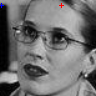

In [133]:
i = 500
y = predictions(cnn_net, torch.Tensor(np.expand_dims(np.array(left_eye_center_x_dataset[i][0]), axis=0)), None)
print(y[0], left_eye_center_x_dataset[i][1])
draw_predicted_target(left_eye_center_x_dataset[i][0], [(y[0],5)], [(left_eye_center_x_dataset[i][1],5)])

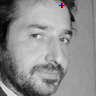

In [130]:
draw_predicted_target(left_eye_center_x_dataset[i][0], [(61,5)], [(62,5)])